# COVID-19 CT Image Classification Using PyTorch



## 1. Data Preparation

* Import dependecies
* Extract file paths and split into training, validation, and test partitions
* Create Dataset Class to process and load images for PyTorch models 

### 1.1 Import all dependencies

In [1]:
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import PIL 
import random
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torchinfo import summary 

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.nn.functional as F

import pydicom
from PIL import Image

import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

Set Random Seed for reproducability

In [3]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
train_pth = 'C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/train_images'
test_pth = 'C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/test_images'
valid_pth = 'C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/valid_images'

In [5]:
import os
import re

def create_dataset(directory):
    dataset = {'path': [], 'label': []}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".png"):  # assuming the images are in .png format
                path = f'{root}/{file}'
                label = re.search('cancer_(.*?)_', file).group(1)
                dataset['path'].append(path)
                dataset['label'].append(int(label))
    return pd.DataFrame(dataset)

train_df = create_dataset(train_pth)
test_df = create_dataset(test_pth)
valid_df = create_dataset(valid_pth)


In [6]:
train_df.head(3)

,path,label
0,C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_...,0
1,C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_...,0
2,C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_...,0


In [7]:
test_df.head(3)

,path,label
0,C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_...,0
1,C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_...,0
2,C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_...,0


In [8]:
valid_df.head(3)

,path,label
0,C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_...,0
1,C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_...,0
2,C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_...,0


In [9]:
sum(list(train_df['label']))

53

In [10]:
train_path, train_label = list(train_df['path']), list(train_df['label'])
test_path, test_label = list(test_df['path']), list(test_df['label'])
valid_path, valid_label = list(valid_df['path']), list(valid_df['label'])

In [11]:
print(f'Number of samples in each set (train, val, test): {len(train_path), len(valid_path), len(test_path)}')

print(f'Number of positive samples in each set: {sum(train_label), sum(valid_label), sum(test_label)}')

Number of samples in each set (train, val, test): (13426, 2847, 2875)
Number of positive samples in each set: (53, 12, 11)


In [12]:
# train_path

In [13]:
total_samples = len(train_path) + len(valid_path) + len(test_path)
pos_samples = sum(train_label) + sum(valid_label) + sum(test_label)

weight_for_cancer = total_samples/(pos_samples * 2)
weight_for_not_cancer = total_samples/(total_samples-pos_samples  * 2)

print(f'The weight for cancer is {weight_for_cancer:.5f} \n\nThe weight for not cancer is {weight_for_not_cancer:.5f} ')

The weight for cancer is 125.97368 

The weight for not cancer is 1.00800 


### Dataset Class



In [14]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None, grayscale=True):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if (img_transforms is None) & (grayscale == True):
            self.transforms = transforms.Compose([transforms.Grayscale(),
                                                  transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        elif grayscale == False:
            self.transforms = transforms.Compose([transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('RGB')
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

## 2. Model Development

### ResNet50

In [15]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(weights=True)
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet50(x)

# class CustomResNet50(nn.Module):
#     def __init__(self, num_classes=1):
#         super(CustomResNet50, self).__init()
#         self.resnet50 = models.resnet50(pretrained=True)
        
#         # Modify the first layer to accept 1 channel input
        
#         in_features = self.resnet50.fc.in_features
#         self.resnet50.fc = nn.Sequential(
#             nn.Linear(in_features, 512),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(512, num_classes)
#         )

#     def forward(self, x):
#         return self.resnet50(x)


### ResNet101

In [16]:
class ResNet101(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet101, self).__init__()
        self.resnet101 = models.resnet101(pretrained=True)
        in_features = self.resnet101.fc.in_features
        self.resnet101.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet101(x)

### EfficientNetB0

In [17]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetB0, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b0')
        in_features = self.effnet._fc.in_features
        self.effnet._fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.effnet(x)


### EfficientNetB4

In [18]:
class EfficientNetB4(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetB4, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b4')
        in_features = self.effnet._fc.in_features
        self.effnet._fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.effnet(x)


### EfficientNetB7

In [19]:
class EfficientNetB7(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetB7, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b7')
        in_features = self.effnet._fc.in_features
        self.effnet._fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.effnet(x)


### VGG16

In [20]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        in_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.vgg16(x)


### Function train_model

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

# Define the training function
def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5,
                patience=7):
    model = model.to(device)

    # Construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # History
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    #Weight for the unbalanced class
    weight = torch.tensor([weight_for_cancer]).to(device)
    # Set up loss function and optimizer
    criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)

    # Initialize variables to track the best validation loss and corresponding model state
    best_val_loss = float('inf')
    best_model_state = None

    # Training Loop
    print("Training Start:")
    for epoch in range(epochs):
        model.train()

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for (images, labels) in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).view(-1)
            labels = labels.view(-1)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            # print(type(outputs))
            # print(type(labels))
            # print(outputs.shape, labels.shape)
            cur_train_loss = criterion(outputs, labels)
            cur_train_acc = (pred == labels).sum().item() / batch_size

            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += cur_train_loss 
            train_acc += cur_train_acc
        
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images).view(-1)

                # print(outputs.shape, labels.shape)
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss

                pred = torch.sigmoid(outputs)
                pred = torch.round(pred)
                val_acc += (pred == labels).sum().item() / batch_size

        scheduler.step()

        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")
    
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
    
        # Update the best model if validation loss is the lowest so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    test_acc = 0
    print(f'The best val loss is {best_val_loss}.\n\n')

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            test_acc += (pred == labels).sum().item()

    print(f'Test Accuracy:  {(test_acc / len(test_loader))}')

    return history, model

Process the datasets and train the model

In [22]:
print("Current GPU memory usage:", torch.cuda.memory_allocated() / (1024 ** 2), "MB")
print("Max GPU memory usage:", torch.cuda.max_memory_allocated() / (1024 ** 2), "MB")

torch.cuda.empty_cache()

Current GPU memory usage: 0.0 MB
Max GPU memory usage: 0.0 MB


In [23]:
len(train_path), len(train_label)

(13426, 13426)

In [24]:
train_dataset = CT_Dataset(img_path=train_path, img_labels=np.array(train_label))
val_dataset = CT_Dataset(img_path=valid_path, img_labels=np.array(valid_label))
test_dataset = CT_Dataset(img_path=test_path, img_labels=np.array(test_label))

In [25]:

# model_resnet50 = ResNet50()
# train_loader = train_model(model_resnet50, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)
651cwcwecwe

SyntaxError: invalid decimal literal (1452862588.py, line 3)

### Training

In [26]:
batch_size = 32
epoch = 5

## Train the ResNet101 model
model_resnet50 = ResNet50()
hist_ResNet50, model_ResNet50 = train_model(model_resnet50, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)


# # Train the ResNet101 model
# model_resnet101 = ResNet101()
# hist_ResNet101, model_ResNet101 = train_model(model_resnet101, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)


# Train the EfficientNetB0 model
# model_efficientnet_b0 = EfficientNetB0()
# hist_EfficientNetB0, model_EfficientNetB0 = train_model(model_efficientnet_b0, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)


# Train the EfficientNetB4 model
# model_efficientnet_b4 = EfficientNetB4()
# hist_EfficientNetB4, model_EfficientNetB4 = train_model(model_efficientnet_b4, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)


# # Train the EfficientNetB7 model
# model_efficientnet_b7 = EfficientNetB7()
# hist_EfficientNetB7, model_EfficientNetB7 = train_model(model_efficientnet_b7, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)


# # Train the VGG16 model
# model_vgg16 = VGG16()
# hist_VGG16, model_VGG16 = train_model(model_vgg16, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)

c:\Users\Lucas\anaconda3\envs\torch000\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Start:
Epoch:1 / 5, lr: 0.00020 train loss:1.07094, train acc: 0.94978, valid loss:1.02629, valid acc:0.99544
Epoch:2 / 5, lr: 0.00020 train loss:0.98494, train acc: 0.99412, valid loss:1.03100, valid acc:0.99544
Epoch:3 / 5, lr: 0.00020 train loss:0.99090, train acc: 0.99375, valid loss:1.19419, valid acc:0.99544
Epoch:4 / 5, lr: 0.00020 train loss:1.03405, train acc: 0.99427, valid loss:1.02113, valid acc:0.99544
Epoch:5 / 5, lr: 0.00010 train loss:0.97612, train acc: 0.99501, valid loss:1.01555, valid acc:0.99544
The best val loss is 1.0155478715896606.


Test Accuracy:  0.9961739130434782


In [27]:
546165sdvsdvsdv

SyntaxError: invalid decimal literal (1495215412.py, line 1)

In [28]:
label_model = "ResNet50_"
hist_kernel = hist_ResNet50
model_kernel = model_ResNet50


In [29]:
path_save_model = f'C:/Users/Lucas/Documents/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/model_/{label_model}{epoch}'

torch.save(model_kernel.state_dict(), f'{path_save_model}.pth')

## Metricis

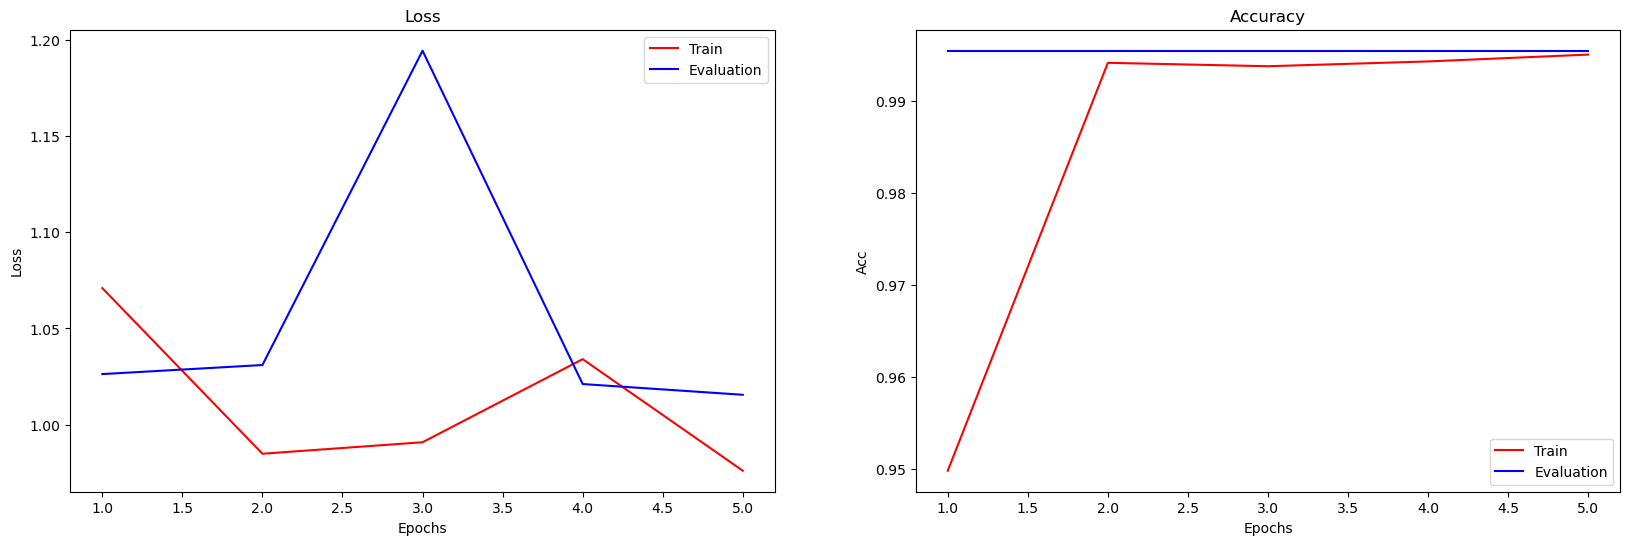

In [30]:
def plot_metrics(hist, label_model) :
    # plot training curves
    epochs = range(1, len(hist['train_loss']) + 1)

    train_loss = [t.cpu().detach().numpy() for t in hist['train_loss']]
    val_loss = [t.cpu().detach().numpy() for t in hist['val_loss']]


    fig, ax = plt.subplots(1,2, figsize=(20,6))
    ax[0].plot(epochs, train_loss, 'r-', label='Train')
    ax[0].plot(epochs, val_loss, 'b-', label='Evaluation')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    plt.savefig(f'{path_save_model}_Loss.png')  # This saves the plot as a PNG image

    ax[1].plot(epochs, hist['train_acc'], 'r-', label='Train')
    ax[1].plot(epochs, hist['val_acc'], 'b-', label='Evaluation')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc')
    ax[1].legend()
    plt.savefig(f'{path_save_model}_Accuracy.png')  # This saves the plot as a PNG image
    

    plt.show()
    
    
plot_metrics(hist_kernel, label_model)

In [33]:
def calculate_metrics(model, test_dataset, device, plot_images=False):
    # Initialize variables to store predictions and ground truth
    y_true = []
    y_pred = []
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions)

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate evaluation metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (fn + tp)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'specificity': specificity,
        'sensitivity': sensitivity,
        'false negativo': fn
    }

    return metrics




model_path = f'{path_save_model}.pth'

if label_model[:7] == "ResNet1":
    model_kernel = ResNet101(num_classes=1)

elif label_model[:7] == "ResNet5":
    model_kernel = ResNet50(num_classes=1)

elif label_model[:14] == "EfficientNetB0":
    model_kernel = EfficientNetB0(num_classes=1)
    
elif label_model[:14] == "EfficientNetB4":
    model_kernel = EfficientNetB4(num_classes=1)

elif label_model[:14] == "EfficientNetB7":
    model_kernel = EfficientNetB7(num_classes=1)

elif label_model[:5] == "VGG16":
    model_kernel = VGG16(num_classes=1)


model_kernel.load_state_dict(torch.load(model_path))
model_kernel.to(device)  # Move the model to the specified device
model_kernel.eval()  # Set the model to evaluation mode

# Call the function with plot_images=True to plot images
metrics = calculate_metrics(model_kernel, test_dataset, device, plot_images=True)
metrics

c:\Users\Lucas\anaconda3\envs\torch000\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'accuracy': 0.9961739130434782,
 'specificity': 1.0,
 'sensitivity': 0.0,
 'false negativo': 11}

In [ ]:
pd.DataFrame(metrics.items(), columns=['Metric', 'Value']).to_csv(f'{path_save_model}.csv')

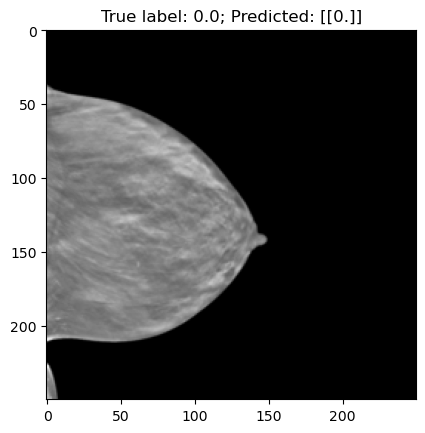

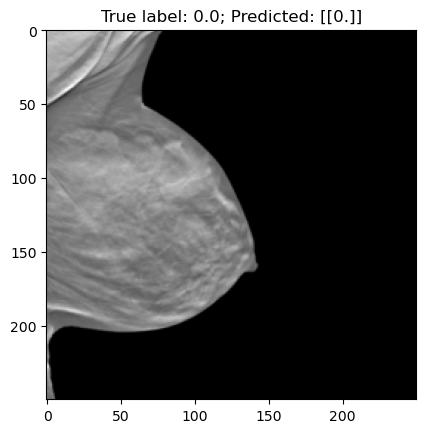

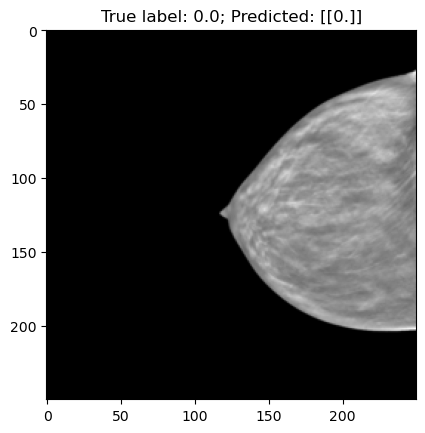

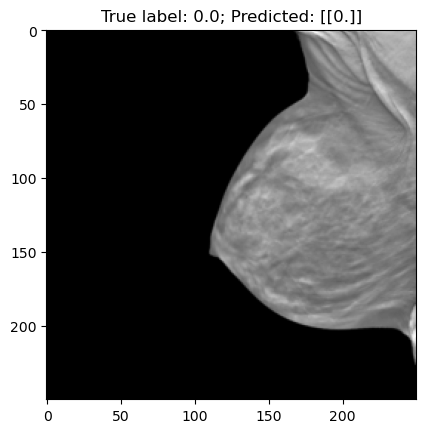

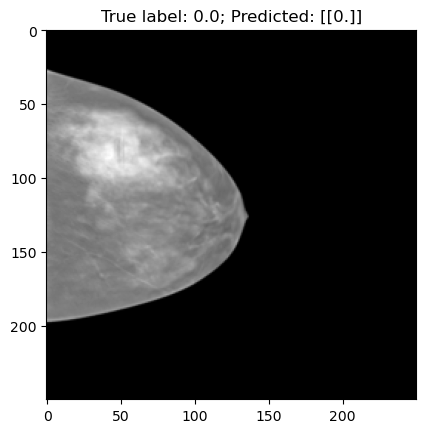

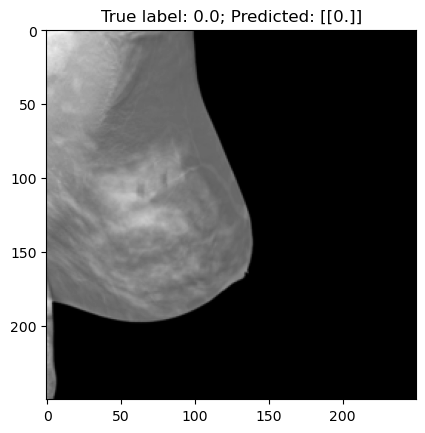

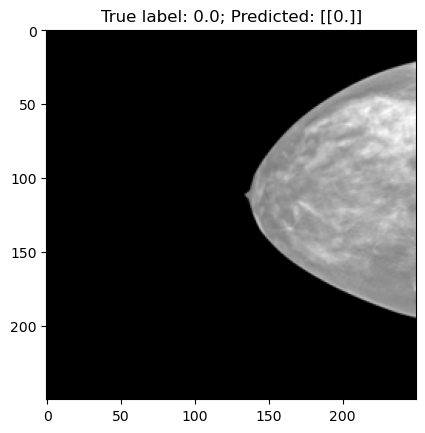

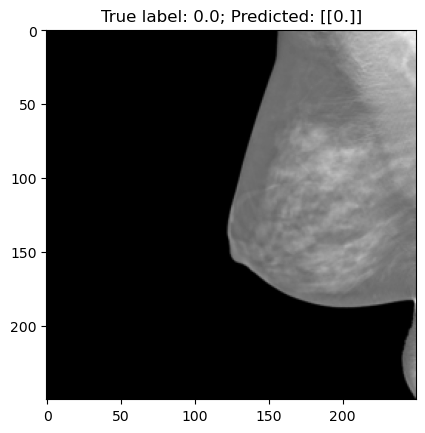

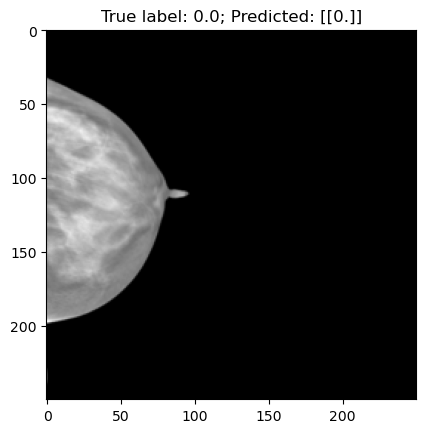

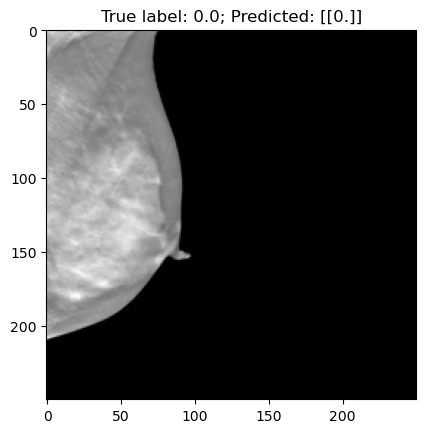

In [34]:
def process_images(model, test_dataset, device, plot_images=False, num_images_to_plot=10):
    # Initialize variables to store predictions and ground truth
    y_pred = []
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    images_plotted = 0  # Counter for the number of images plotted

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            y_pred.extend(predictions)

            # Plot images with true and predicted labels
            if plot_images and images_plotted < num_images_to_plot:
                plot_image(images, labels, predictions)
                images_plotted += 1

            # Break the loop if the desired number of images is plotted
            if images_plotted >= num_images_to_plot:
                break


def plot_image(images, true_label, predicted_label):
    if len(images.shape) == 4 and images.shape[1] == 3:
        # Convert CUDA tensor to numpy array and rearrange dimensions for RGB image
        images = images.cpu().detach().numpy().squeeze().transpose((1, 2, 0))
    else:
        # Convert CUDA tensor to numpy array and squeeze if necessary
        images = images.cpu().detach().numpy().squeeze()

    if len(images.shape) == 2:
        plt.imshow(images, cmap='gray')
    else:
        plt.imshow(images)
    
    # Format the labels
    true_label = true_label.item() if isinstance(true_label, torch.Tensor) else true_label
    predicted_label = predicted_label.item() if isinstance(predicted_label, torch.Tensor) else predicted_label
    
    plt.title(f'True label: {true_label}; Predicted: {predicted_label}')
    plt.show()
    
    
process_images(model_kernel, test_dataset, device, plot_images=True)

**Sugestão de Próximos Passos**

1. Colocar para salvar o modelo com a menor validation loss.
2. Colocar código para carregar o modelo salvo e fazer predições em imagens do dataset.
3. Criar métricas de acurácia (Accuracy, Precision, Recall, F-score, etc.) para avaliar o dataset de teste com o modelo salvo.

Quando tudo estiver pronto:
4. Criar novos modelos CNN (começar pela ResNet101).
5. Implementar outros modelos.

Quando estiver pronto:
6. Implementar no seu dataset.


Para binário tem que mudar a loss (CrossEntropy), a sigmoid da layer final para softmax

# Materiais e Métodos

## 1. Datasets

Explicação sobre os conjuntos de dados utilizados.

## 2. Modelos

Explicação sobre como funciona um modelo CNN (Convolutional Neural Network) e os parâmetros utilizados.

### 2.1. EfficientNet

### 2.2. ResNet101

...

## 3. Métricas
